In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import re

/home/acarvallo/virtual_env/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# training

In [2]:
df_train = pd.read_csv('path/to/Epistemonikos_train_dataset.tsv', sep='\t', index_col = 'id_')

df_train.dropna(inplace=True)

df_train.head()

,abstract,label,title
id_,,,
0000022f5cdf38fb5185f142f61b89fe111e5463,Objective: The inflammatory reaction observed ...,systematic-review,"Association of polymorphisms in IL-4, IL-5, IL..."
0000299520b8c9530fd4ce2e1958597bdd3995b7,BACKGROUND: Olanzapine is frequently prescribe...,systematic-review,The safety of olanzapine in young children: a ...
0000b4bdffa6bfe9dfa563b22e040c990878c8cb,BACKGROUNDS: Osteopontin (OPN) has been report...,systematic-review,Comparison osteopontin vs AFP for the diagnosi...
0000e029fdca1d8e63d58c401a2f7a01dce54e31,We report the case of a 52-yr-old man with met...,primary-not-rct,Acute tumor lysis syndrome triggered by zoledr...
000162f03a455142bd61de2a26792316ffe25aa1,"Hypertension, a leading cause of morbidity and...",systematic-review,Angiotensin-converting enzyme inhibitors and s...


## tokenizer

In [3]:
# -*- coding: utf-8 -*-

import re

STOPWORDS = {
    "en": [
        "several", "on", "while", "than", "own", "you've", "itself", "above", "such", "over", "they're", "mainly", "because", "theirs", "too", "most", "must", "myself", "that", "why's", "it", "can't", "show", "overall", "she", "he'd", "it's", "can", "under", "no", "she'll", "should", "therefore", "his", "you", "various", "mustn't", "are", "doing", "really", "up", "they'd", "having", "these", "made", "we'll", "into", "you'll", "more", "ought", "especially", "hasn't", "seem", "nor", "shows", "here's", "here", "he's", "is", "at", "ml", "always", "nearly", "during", "ours", "this", "aren't", "rather", "being", "very", "shown", "them", "cannot", "just", "or", "where", "didn't", "another", "they'll", "shouldn't", "wasn't", "for", "when's", "in", "could", "off", "down", "further", "won't", "due", "however", "each", "i'd", "a", "that's", "where's", "enough", "neither", "its", "isn't", "any", "himself", "was", "they've", "etc", "there's", "whom", "both", "other", "by", "within", "not", "been", "below", "be", "once", "make", "does", "did", "before", "through", "shan't", "ourselves", "which", "kg", "their", "again", "thus", "about", "few", "either", "they", "do", "our", "you'd", "some", "don't", "although", "almost", "i'll", "often", "i'm", "she'd", "we'd", "yourselves", "using", "between", "if", "upon", "him", "we", "done", "as", "so", "hers", "me", "she's", "there", "and", "i've", "may", "but", "with", "how", "found", "her", "yours", "might", "then", "we've", "the", "yourself", "what's", "km", "without", "same", "those", "my", "perhaps", "all", "haven't", "of", "why", "has", "had", "regarding", "significantly", "when", "i", "until", "used", "would", "among", "what", "let's", "am", "how's", "who's", "weren't", "mm", "hadn't", "have", "mg", "wouldn't", "showed", "were", "an", "we're", "obtained", "themselves", "who", "your", "out", "to", "doesn't", "he", "herself", "pmid", "against", "use", "you're", "couldn't", "after", "he'll", "only", "also", "mostly", "quite", "seen", "since"
    ]
}

NUMBERS_STOPWORDS = {
    "en": [
        "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen", "twenty", "twenty-one", "twenty-two", "twenty-three", "twenty-four", "twenty-five", "twenty-six", "twenty-seven", "twenty-eight", "twenty-nine", "thirty", "thirty-one", "thirty-two", "thirty-three", "thirty-four", "thirty-five", "thirty-six", "thirty-seven", "thirty-eight", "thirty-nine", "forty", "forty-one", "forty-two", "forty-three", "forty-four", "forty-five", "forty-six", "forty-seven", "forty-eight", "forty-nine", "fifty", "fifty-one", "fifty-two", "fifty-three", "fifty-four", "fifty-five", "fifty-six", "fifty-seven", "fifty-eight", "fifty-nine", "sixty", "sixty-one", "sixty-two", "sixty-three", "sixty-four", "sixty-five", "sixty-six", "sixty-seven", "sixty-eight", "sixty-nine", "seventy", "seventy-one", "seventy-two", "seventy-three", "seventy-four", "seventy-five", "seventy-six", "seventy-seven", "seventy-eight", "seventy-nine", "eighty", "eighty-one", "eighty-two", "eighty-three", "eighty-four", "eighty-five", "eighty-six", "eighty-seven", "eighty-eight", "eighty-nine", "ninety", "ninety-one", "ninety-two", "ninety-three", "ninety-four", "ninety-five", "ninety-six", "ninety-seven", "ninety-eight", "ninety-nine"
    ]
}

# Tokenize


def tokenize_one(text, stopwords=None, additional_stopwords=None, lang="en"):
    if stopwords is None:
        stopwords = STOPWORDS[lang] + NUMBERS_STOPWORDS[lang]
    if additional_stopwords:
        stopwords += additional_stopwords
    stopwords = [
        stopword
        for stopword in stopwords
        if stopword
    ]
    text_part = text.lower()

    # Must be executed in order
    regexs = [
        # Remove all stopwords by a !, we are searching for the stopword (bounded)
        ("\\b" + "\\b|\\b".join(stopwords), "!!"),
        ("’", "'"),
        # Remove all non alpha, numeric, spaces, - or single quote
        (r'([^a-z0-9\u00C0-\u1FFF\u2C00-\uD7FF \t\n\-\'])', "!!"),
        # remove only words numbers
        (r'(^|[ !])[0-9]+([ !]|$)', "!!"),
        # remove hyphen-minus for keywords starting or ending with it
        (r'((^|[ !])[\-\']+)|([\-\']+([ !]|$))', "!!"),
        # remove spaces between !
        (r' *! *', "!!"),
        # generate multiple ! need for next regex
        (r'!', "!!"),
        # remove one character keyword
        (r'(^|!)[^!\n](!|$)', "!!"),
        # remove multiple ! (!!!!)
        (r'!+', "!"),
        # remove first and last !
        (r'(^!+)|(!+$)', ""),
    ]
    for regex, replacement in regexs:
        text_part = re.sub(regex, replacement, text_part, flags=re.M)
    return text_part

## prepare features

In [4]:
TERMS_IN_TEXT = {
    "groups": {
        'systematic_review': {
            'phrases': [
                "systematic review",
                "systemic review",
                "meta-analysis",
                "metaanalysis",
                "meta analysis",
                "meta-synthesis",
                "meta synthesis",
                "metasynthesis",
                "systematic quantitative review",
                "meta-analytic review",
                "systematic literature review"
            ],

        },
        'databases': {
            'phrases': [
                "pubmed", "medline", "embase", "cinahl", "cochrane", "lilacs",
                "scopus", "psycinfo", "science direct", "google scholar", "databases"
            ],
            "search_in": ("abstract",)
            
        },
        'several_studies': {
            'phrases': [
                "controlled trials",
                "studies included",
                "randomized controlled trials",
                "included studies",
                "rcts",
                "trials rcts",
                "observational studies",
                "abstracts",
                "studies met inclusion",
                "total studies",
                "randomized trials",
                "randomised trials",
                "retrospective studies",
                "anecdotal reports",
                "prospective studies",
                "qualitative studies",
                "these studies",
                "identified studies",
                "studies identified",
                "studies were selected",
                "published studies",
                "randomized studies",
                "trials were included",
                "all studies",
                "clinical studies",
                "papers were found",
                "articles were found",
                "studies were found",
                "systematic search identified",
                "systematic literature searches"
            ],
            'regex': [
                r"three (studies|trials|articles|reports|abstracts)",
                r"four (studies|trials|articles|reports|abstracts)",
                r"five (studies|trials|articles|reports|abstracts)",
                r"six (studies|trials|articles|reports|abstracts)",
                r"seven (studies|trials|articles|reports|abstracts)",
                r"eight (studies|trials|articles|reports|abstracts)",
                r"nine (studies|trials|articles|reports|abstracts)",
                r"ten (studies|trials|articles|reports|abstracts)",
                r"[0-9]+ (studies|trials|articles|reports|abstracts)",
                r"evidence.*studies",
                r"studies.*evidence",
            ]
        },
        'date_of_publication': {
            'phrases': [
                "published in",
                "published from",
                "published before",
                "published since",
                "published until",
                "published after",
                "published to",
                "published during",
                "published within",
            ],
            'regex': [
                r"(^|[^0-9])[12][890][0-9]{2} to [12][890][0-9]{2}($|[^0-9])",
                r"between.*[12][890][0-9]{2} and .*[12][890][0-9]{2}($|[^0-9])",
                r"from.*[12][890][0-9]{2} to .*[12][890][0-9]{2}"
            ]
        },
        'a_review': {
            'phrases': [
                "a review",
                "review of",
                "our review"
            ],
            'regex': [
                r": review\b",
            ],
            "search_in": ("title",)
        },
        'almost_systematic_review': {
            'phrases': [
                'meta-study',
                'this review',
                'prisma'

            ],
            'regex': [
                r'(\breview\b.*\bsystematic\b)|(\bsystematic\b.*\breview\b)',
                r'(\breview\b.*\bsystematic\b)|(\bsystematic\b.*\breview\b)',
            ]
        },
        'review_other_names': {
            'phrases': [
                "literature review",
                "review the literature",
                "literature search",
                "critical review",
                "evidence-based review",
                "evidence-based analysis",
                "synthesis of the literature",
                "meta-analytic study",
                "integrative review",
                "evidence assessment",
                "meta-analytical review",
                "pooled",
                "quantitative review",
                "manual search",
            ],
            'regex': [
                r"review(\s|\s+[^ ]+\s?|\s?[^ ]+\s+){0,5}randomized",  ## 5 palabras de distancia
                r"critical(\s|\s+[^ ]+\s?|\s?[^ ]+\s+){0,5}literature",  ## 5 palabras de distancia
            ]
        },
        'guideline': {
            'phrases': [
                'guidelines', 'guideline', 'overview systematic',
                'statement', 'recommendations', 'expert panel'
            ],
            "search_in": ("title",)
        },
        'possible_guideline': {
            'phrases': ['systematic reviews'],
        },
        'excluded_words': {
            'phrases': [
                'commentary', 'reply', 're:', 'in response',
                'editorial', 'errata', 'erratum', 'corrigendum',
                'letter by', 'letter to the editor'
            ],
            'regex': [
                r"response to \"",
                r"response to '",
                r"response to:",
                r"letter:",
                r"letter\.\.",
                r"reponse to (the )?(comment|letter|metaanalysis|meta-analysis|systematic|cochrane)",
                r"reply to (the )?(comment|letter|metaanalysis|meta-analysis|systematic|cochrane)",
                r"reply to .*([\s]et al[^\w]|$)",
            ],
            "search_in": ("title",)
        },
        "related_words": {
            "phrases": [
                "meta-analyses",
                "meta-analytic",
                "indirect treatment comparison"
            ]
        },
        "excluded_protocol": {
            "tokens": [
                "review will",
                "systematic review will",
                "systematic review protocol",
                "following databases will",
                "meta-analysis will",
                "review will focus",
                "will assess",
                "results will",
                "review will include studies"
            ]
        },
        "animals": {
            "tokens": [
                "rats",
                "mice",
                "animal model",
                "animal models",
                "animals",
                "species",
                "mouse models",
                "rabbits",
                "rat",
                "animal studies",
                "dogs",
                "vivo",
                "mouse",
                "animal",
                "preclinical studies",
                "humans",
                "model",
                "cattle",
                "rats systematic review",
                "killed",
                "animal models systematic review",
                "birds",
                "vitro",
                "experimental model",
                "cats",
                "sheep",
                "dog",
                "models",
                "vivo studies",
                "experimental models",
                "animal trials",
            ]
        },
        "psyc_terms": {
            "tokens": [
                "american psychological association",
                "psycinfo database record",
                "psychnet",
                "psychological index terms",
                "academic psychology"
            ],
            "search_in": ("abstract",)
        },
        "studies": {
            "phrases": [
                "studies",
                "papers",
                "trials"
            ],
            "search_in": ("abstract",)
        },
        "included": {
            "phrases": [
                "included",
                "eligible",
                "selected"
            ],
            "search_in": ("abstract",)
        },
        "searched": {
            "phrases": [
                "searched",
                "systematic search",
                "search included",
                "retrieved"
            ],
            "search_in": ("abstract",)
        },
        "criteria": {
            "phrases": [
                "inclusion criteria",
                "eligibility criteria"
            ],
            "search_in": ("abstract",)
        }
    },
    "terms": {
        "title": [
             'effectiveness',
             'protocol',
             'systematic review',
             'systematic review protocol',
             'meta-analysis'
        ],
        "abstract": [
            'apa',
            'studies',
            'psycinfo database record',
            'ci',
            'embase',
            'included',
            'results',
            'conclusions',
            'meta-analysis',
            'patients',
            'systematic review',
            'methods',
            'medline',
            'performed',
            'background',
            'conclusion',
            'pubmed',
            'total',
            'confidence interval',
            'treatment',
            'review',
            'objective',
            'conducted',
            'study',
            'associated',
            'searched',
            'identified',
            'risk'
        ]
    }
}

In [5]:
COLUMNS = []
for target in ('title', 'abstract'):
    for key in TERMS_IN_TEXT.get("groups", {}).keys():
        key_for_found = "%s_%s" % (key, target)
        if target not in TERMS_IN_TEXT.get("groups", {})[key].get("search_in", ['title', 'abstract']):
            continue
        COLUMNS += [key_for_found, ]
COLUMNS += [
    ("title: " + key[:20] + '...') if len(key) > 20 else "title: " +key
    for key in TERMS_IN_TEXT.get("terms", {}).get("title", [])
] + [
    ("abstract: " + key[:20] + '...') if len(key) > 20 else "abstract: " + key
    for key in TERMS_IN_TEXT.get("terms", {}).get("abstract", [])
]


def find_matches(row):
    title = row["title"]
    abstract = row["abstract"]
    tokenized = {
        "title": tokenize_one(title),
         "abstract": tokenize_one(abstract)
    }
    row = []
    for target, value in (('title', title), ('abstract', abstract)):
        for key in TERMS_IN_TEXT.get("groups", {}).keys():
            if target not in TERMS_IN_TEXT.get("groups", {})[key].get("search_in", ['title', 'abstract']):
                continue
            was_found = 0
            for phrase in TERMS_IN_TEXT.get("groups", {})[key].get('phrases', []):
                if re.search(r'(^|[^\w])' + phrase + r'($|[^\w])', value):
                    was_found = 1
                    break
            for phrase in TERMS_IN_TEXT.get("groups", {})[key].get('regex', []):
                if re.search(phrase, value):
                    was_found = 1
                    break
            for token in TERMS_IN_TEXT.get("groups", {})[key].get('tokens', []):
                if token in tokenized[target]:
                    was_found = 1
                    break
            row.append(was_found)
    for target_place in ("title", "abstract"):
        for text in TERMS_IN_TEXT.get("terms", {}).get(target_place) or []:
            was_found = 0
            if text in tokenized[target_place]:
                was_found = 1
            row.append(was_found)
    return row

In [6]:
from multiprocessing import Pool, cpu_count
cpu_num = max(1, cpu_count())
pool_queue = Pool(cpu_num)

print(len(df_train))
rows_train = pool_queue.map(find_matches, [
    {"title": row["title"], "abstract": row["abstract"]}
    for _, row in df_train.iterrows()
])

399737


In [7]:
df_train_processed = pd.DataFrame(rows_train, columns=COLUMNS)
df_train_processed.head()

,several_studies_title,review_other_names_title,date_of_publication_title,guideline_title,systematic_review_title,a_review_title,excluded_words_title,related_words_title,excluded_protocol_title,almost_systematic_review_title,...,abstract: confidence interval,abstract: treatment,abstract: review,abstract: objective,abstract: conducted,abstract: study,abstract: associated,abstract: searched,abstract: identified,abstract: risk
0,0,0,0,0,1,0,0,0,0,1,...,0,0,1,1,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0,1,...,1,0,1,1,0,0,1,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [8]:
y_train = np.array(df_train.label)
y_train

array(['systematic-review', 'systematic-review', 'systematic-review', ...,
       'systematic-review', 'systematic-review', 'primary-rct'],
      dtype=object)

# testing

In [9]:
# LOAD CORD-19
df_test = pd.read_csv('path/to/test/CORD19_full_labels.csv', sep='\t')

df_test = df_test[['abstract', 'pubmed_id', 'label', 'title']]

# drop document with no abstract
df_test.dropna(subset = ['title', 'abstract'], inplace=True)

df_test.index = df_test['pubmed_id']

df_test.head()

,abstract,pubmed_id,label,title
pubmed_id,,,,
32572175,The lack of effective pharmaceutical intervent...,32572175,primary-not-rct,The end of social confinement and COVID-19 re-...
33079612,Operation Warp Speed and global vaccine resear...,33079612,excluded,The Missing Link in the Covid-19 Vaccine Race.
33565705,We describe a case of proven transmission of S...,33565705,primary-not-rct,Donor To Recipient Transmission Of SARS-CoV-2 ...
33479162,OBJECTIVES To describe neonatal and maternal c...,33479162,primary-not-rct,Neonates Born to Mothers With COVID-19: Data F...
33705595,SARS-CoV-2 virus has triggered a global pandem...,33705595,excluded,New targets for drug design: Importance of nsp...


In [10]:
from multiprocessing import Pool, cpu_count
cpu_num = max(1, cpu_count())
pool_queue = Pool(cpu_num)

print(len(df_test))
rows_test = pool_queue.map(find_matches, [
    {"title": row["title"], "abstract": row["abstract"]}
    for _, row in df_test.iterrows()
])

18854


In [11]:
df_test_processed = pd.DataFrame(rows_test, columns=COLUMNS)
df_test_processed.head()

,several_studies_title,review_other_names_title,date_of_publication_title,guideline_title,systematic_review_title,a_review_title,excluded_words_title,related_words_title,excluded_protocol_title,almost_systematic_review_title,...,abstract: confidence interval,abstract: treatment,abstract: review,abstract: objective,abstract: conducted,abstract: study,abstract: associated,abstract: searched,abstract: identified,abstract: risk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Random Forest 

In [12]:
n_estimators = 100

# Instantiate model with 100 decision trees, other params default 
rf100 = RandomForestClassifier(n_estimators = n_estimators, n_jobs=-1)

# Train the model on training data_
rf100.fit(df_train_processed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
predicted_proba = rf100.predict_proba(df_test_processed)

predicted_raw = [
    "\t".join([
        str(x)
        for x in row
    ])
    for row in predicted_proba
]

In [14]:
prediction = rf100.predict(df_test_processed)

In [15]:
prediction

array(['primary-not-rct', 'excluded', 'primary-not-rct', ...,
       'primary-not-rct', 'excluded', 'primary-rct'], dtype=object)

In [16]:
df_test['prediction'] = prediction

In [17]:
df_test

,abstract,pubmed_id,label,title,prediction
pubmed_id,,,,,
32572175,The lack of effective pharmaceutical intervent...,32572175,primary-not-rct,The end of social confinement and COVID-19 re-...,primary-not-rct
33079612,Operation Warp Speed and global vaccine resear...,33079612,excluded,The Missing Link in the Covid-19 Vaccine Race.,excluded
33565705,We describe a case of proven transmission of S...,33565705,primary-not-rct,Donor To Recipient Transmission Of SARS-CoV-2 ...,primary-not-rct
33479162,OBJECTIVES To describe neonatal and maternal c...,33479162,primary-not-rct,Neonates Born to Mothers With COVID-19: Data F...,primary-not-rct
33705595,SARS-CoV-2 virus has triggered a global pandem...,33705595,excluded,New targets for drug design: Importance of nsp...,primary-rct
33771818,Anticipating the need for a COVID-19 treatment...,33771818,primary-not-rct,Establishing a COVID-19 treatment centre in Is...,primary-rct
32890322,The coronavirus disease 2019 is caused by the ...,32890322,broad-synthesis,Guidelines for Ultrasound in the Radiology Dep...,primary-not-rct
33381888,We read with great interest the study by Berti...,33381888,primary-not-rct,Antiphospholipid antibodies and thrombosis in ...,primary-rct
32628408,PURPOSE OF REVIEW To provide aids to deal with...,32628408,excluded,Nonoperating room anesthesia for patients with...,excluded



RESULTS RANDOM FOREST 


[Text(69,0.5,'True Label'), Text(0.5,42,'Predicted Label')]

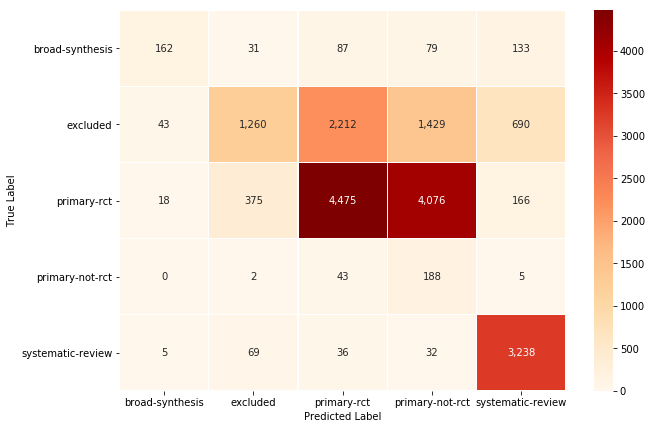

In [22]:
gt = np.array(df_test.label)
preds = np.array(df_test.prediction)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix

print('\nRESULTS RANDOM FOREST ')

array = confusion_matrix(gt, preds)

df_cm = pd.DataFrame(array, index = [i for i in [ 'broad-synthesis', 'excluded' , 'primary-not-rct' , 'primary-rct' , 'systematic-review']],
                  columns = [i for i in [ 'broad-synthesis', 'excluded' , 'primary-not-rct' , 'primary-rct' , 'systematic-review']])

plt.figure(figsize = (10,7))

ax = sn.heatmap(df_cm, linewidths = 0.5, xticklabels = True, yticklabels = True, cmap = "OrRd", annot = True, fmt = "d")

for t in ax.texts:
    t.set_text('{:,d}'.format(int(t.get_text())))

ax.set(xlabel='Predicted Label', ylabel='True Label')


In [19]:
from sklearn.metrics import classification_report
print(classification_report(gt, preds))

                   precision    recall  f1-score   support

  broad-synthesis       0.71      0.33      0.45       492
         excluded       0.73      0.22      0.34      5634
  primary-not-rct       0.65      0.49      0.56      9110
      primary-rct       0.03      0.79      0.06       238
systematic-review       0.77      0.96      0.85      3380

      avg / total       0.69      0.49      0.54     18854

